In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep

In [2]:
from PIL import Image
from io import BytesIO
from adjustText import adjust_text

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

In [4]:
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder

In [5]:
from nba_api.stats.static.players import find_players_by_full_name

In [6]:
from nba_api.stats.static.teams import find_teams_by_full_name

In [7]:
headers= {
    'Host': 'stats.nba.com', 
    'Connection': 'keep-alive', 
    'Accept': 'application/json, text/plain, */*', 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
    'Referer': 'https://stats.nba.com/', 
    'Accept-Encoding': 'gzip, deflate, br', 
    'Accept-Language': 'en-US,en;q=0.9',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
}

In [8]:
def get_data_pbp(game_id):
    game_url = f"https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2019/scores/pbp/{game_id}_full_pbp.json"
    resp = requests.get(game_url)
    data = resp.json()
    pl_data = data['g']['pd']
    data_dfs = []
    for i in range(4):
        data_pbp_df = pd.DataFrame.from_records(pl_data[i]['pla'])
        data_dfs.append(data_pbp_df)

    return pd.concat(data_dfs, ignore_index=True)

In [9]:
def get_pbp_dfs(player_id, team_id):
    game_finder = LeagueGameFinder(player_or_team_abbreviation='P', season_nullable='2019-20', player_id_nullable=player_id, team_id_nullable=team_id, season_type_nullable='Regular Season')
    games = game_finder.get_data_frames()[0]
    data_frames = []
    stats_dfs = []
    data_dfs = []
    for game_id in tqdm.tqdm(games.GAME_ID.unique().tolist()):
        stats_pbp = PlayByPlayV2(game_id=game_id)
        stats_pbp_df = stats_pbp.get_data_frames()[0]
        data_pbp = get_data_pbp(game_id=game_id)
        data_pbp.loc[:, 'GAME_ID'] = game_id
        merged = pd.merge(left=stats_pbp_df, right=data_pbp, left_on=('EVENTNUM'), right_on=('evt'), suffixes=('_stats', '_data'))
        stats_dfs.append(stats_pbp_df)
        data_dfs.append(data_pbp)
        data_frames.append(merged)
        sleep(0.5)
    return pd.concat(data_frames, ignore_index=True), pd.concat(stats_dfs, ignore_index=True), pd.concat(data_dfs, ignore_index=True)

In [10]:
lopez_id = find_players_by_full_name('Brook Lopez')[0]['id']

In [11]:
bucks_id = '1610612749'

In [12]:
pbp_df, stats_dfs, data_dfs = get_pbp_dfs(player_id=lopez_id, team_id=bucks_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:42<00:00,  2.00s/it]


In [13]:
pbp_df.locX = -pbp_df.locX

In [14]:
copy_df = pbp_df

## Drawing Shot Chart

In [15]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [16]:
from matplotlib import patches

In [17]:
def plot_raw_shotchart(data_frame, title, mode="dark"):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    
    if mode == 'dark':
        background_color="#000000"
        font_color="#FFFFFF"    
        marker_color = '#00471B'
        line_color = "#EEE1C6"
        edge_color = "#EEE1C6"
    else:
        background_color="#EEE1C6"
        font_color = "#000000"
        marker_color = '#00471B'
        line_color = "#000000"
        edge_color = "#000000"
    
    
    paths = ax.scatter(
        x=data_frame.locX,
        y=data_frame.locY,
        marker='o',
        c=marker_color,
        s=180,
        zorder=1,
        lw=1,
        edgecolors=edge_color,
        label='Blocked Shot'
    )

    
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    
    team_id = int(data_frame.iloc[0].PLAYER3_TEAM_ID)
    player_id = data_frame.iloc[0].PLAYER3_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(132, 252, -48, 40))
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(background_color)
    frame.set_linewidth(2)
    for text in legend.get_texts():
        text.set_color(font_color)
    
    ax.set_facecolor(background_color)
    fig.set_facecolor(background_color)
    ax.set_frame_on(False)
    
    # Title
    plt.title(title, size=26, color=font_color)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=line_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    

In [18]:
lopez_blocks = pbp_df.loc[((pbp_df.PLAYER2_ID == lopez_id) | (pbp_df.PLAYER3_ID == lopez_id)) & ((pbp_df.HOMEDESCRIPTION.str.contains('BLK', na=False)) | (pbp_df.VISITORDESCRIPTION.str.contains('BLK', na=False)))]

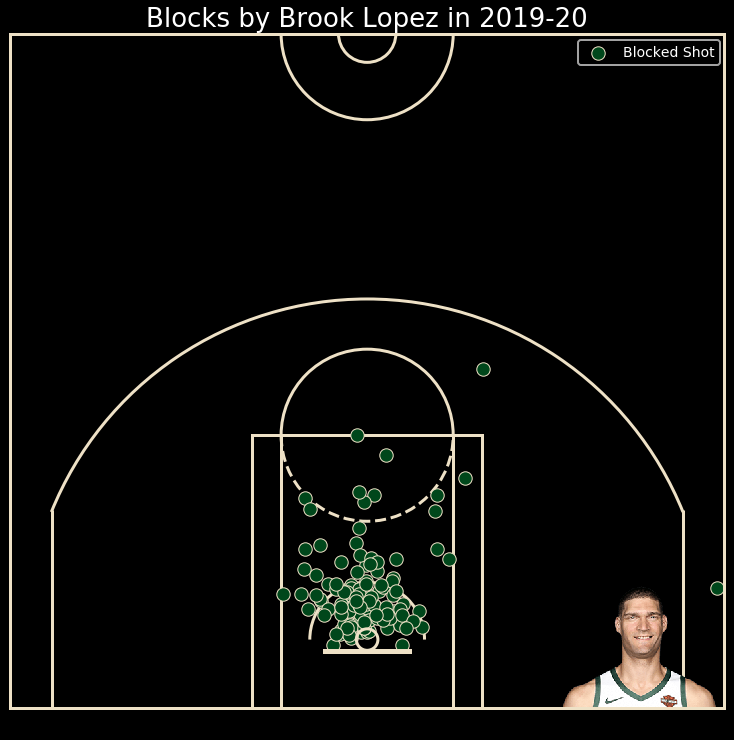

In [19]:
plot_raw_shotchart(data_frame=lopez_blocks, title="Blocks by Brook Lopez in 2019-20", mode='dark')

## Defensive strategy

* Pack the paint

* Allow three pointers to low fg% shooters

* allow mid-range

* Don't switch, but rather double the player when he crashes the paint

* Very different than Jazz' strategy with Rudy

In [20]:
from nba_api.stats.endpoints.leaguedashptdefend import LeagueDashPtDefend

In [21]:
defense_dash = LeagueDashPtDefend(per_mode_simple='PerGame')

In [22]:
defense_df = defense_dash.get_data_frames()[0]

In [23]:
defense_df = defense_df.loc[defense_df.GP > 15]

In [24]:
centers_df = defense_df.loc[defense_df.PLAYER_POSITION.str.contains('C')]

In [25]:
plt.style.use('fivethirtyeight')

In [26]:
over_ten_shots = defense_df.loc[defense_df.D_FGA > 10]

In [27]:
sorted_over_ten = over_ten_shots.sort_values(by='D_FG_PCT', ascending=True)

In [28]:
bucks_defenders = defense_df.loc[defense_df.PLAYER_LAST_TEAM_ABBREVIATION == 'MIL']
other_defenders = defense_df.loc[defense_df.PLAYER_LAST_TEAM_ABBREVIATION != 'MIL']

500

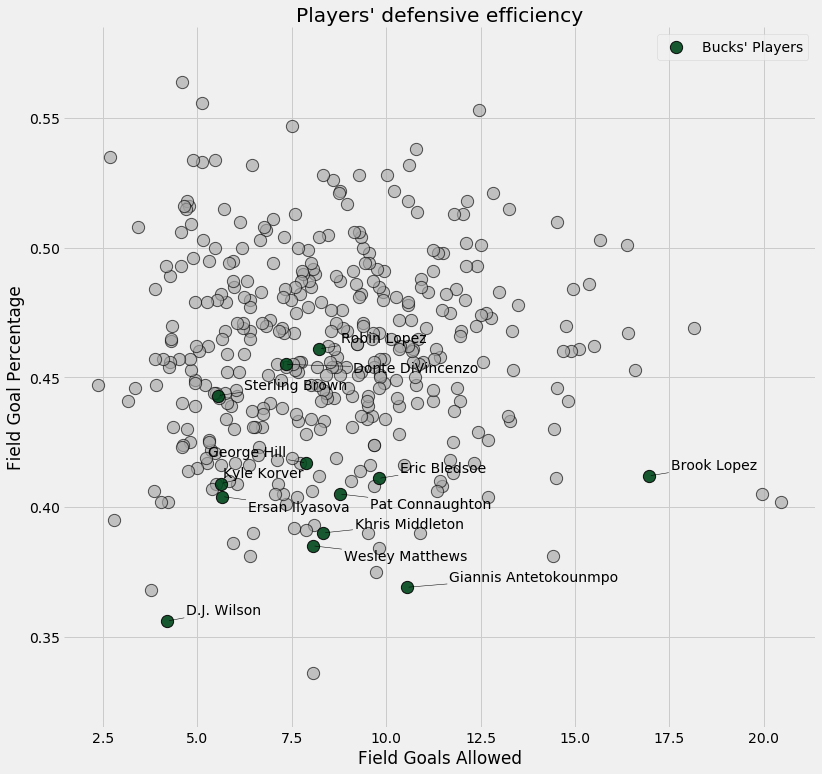

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))


ax.scatter(x=other_defenders.D_FGA, y=other_defenders.D_FG_PCT, s=150, alpha=0.65, lw=1, edgecolors='black', c='#A7A7A7')
ax.scatter(x=bucks_defenders.D_FGA, y=bucks_defenders.D_FG_PCT, s=150, alpha=0.9, lw=1, edgecolors='black', c='#00471B', linewidths=1, label="Bucks' Players")

ax.set_frame_on(False)

texts = []

for index in range(len(bucks_defenders)):
    item = bucks_defenders.iloc[index]
    texts.append(ax.text(x=item.D_FGA, y=item.D_FG_PCT, s=item.PLAYER_NAME))


ax.set_xlabel("Field Goals Allowed")
ax.set_ylabel("Field Goal Percentage")
ax.set_title("Players' defensive efficiency")
ax.legend()

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.5, 1.5))

You can see that in general all Bucks' defenders are extremly good, and they hold defenders to low percentages.

Lopez' defensive percentages are really good given the fact that most of the shots are in the paint.

In [30]:
def get_breakdown_by_position(player_id):
    url = f"https://stats.nba.com/stats/matchupsrollup?DateFrom=&DateTo=&DefPlayerID={player_id}&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"
    headers= {
        'Host': 'stats.nba.com', 
        'Connection': 'keep-alive', 
        'Accept': 'application/json, text/plain, */*', 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
        'Referer': 'https://stats.nba.com/', 
        'Accept-Encoding': 'gzip, deflate, br', 
        'Accept-Language': 'en-US,en;q=0.9',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
    }
    response = requests.get(url, headers=headers)
    json_data = response.json()
    headers = json_data["resultSets"][0]["headers"]
    data = json_data["resultSets"][0]["rowSet"]
    df = pd.DataFrame(data=data, columns=headers)
    #df = df.loc[df.POS.isin(['F', 'C', 'G'])]
    return df

In [31]:
centers_ten_df = centers_df.loc[centers_df.D_FGA > 10]

In [32]:
data_frames = []

for index in tqdm.tqdm(range(len(centers_ten_df))):
    item = centers_ten_df.iloc[index]
    data_frames.append(get_breakdown_by_position(item.CLOSE_DEF_PERSON_ID))
    sleep(0.25)
concated_df = pd.concat(data_frames, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:51<00:00,  2.65s/it]


In [33]:
forwards_df = concated_df.loc[concated_df.POSITION == 'F']
centers_df = concated_df.loc[concated_df.POSITION == 'C']
guards_df = concated_df.loc[concated_df.POSITION == 'G']
total_df = concated_df.loc[concated_df.POSITION == 'TOTAL']

In [34]:
sorted_total_df = total_df.sort_values(by='MATCHUP_FGA', ascending=False).iloc[:15]

In [35]:
filtered_forwards = forwards_df.loc[forwards_df.DEF_PLAYER_NAME.isin(sorted_total_df.DEF_PLAYER_NAME.tolist())]
filtered_centers = centers_df.loc[centers_df.DEF_PLAYER_NAME.isin(sorted_total_df.DEF_PLAYER_NAME.tolist())]
filtered_guards = guards_df.loc[guards_df.DEF_PLAYER_NAME.isin(sorted_total_df.DEF_PLAYER_NAME.tolist())]

In [36]:
filtered_centers = filtered_centers.sort_values(by='DEF_PLAYER_NAME')
filtered_forwards = filtered_forwards.sort_values(by='DEF_PLAYER_NAME')
filtered_guards = filtered_guards.sort_values(by='DEF_PLAYER_NAME')

In [37]:
merged = pd.merge(left=centers_df, right=guards_df, on='DEF_PLAYER_ID', suffixes=('_centers', '_guards'))

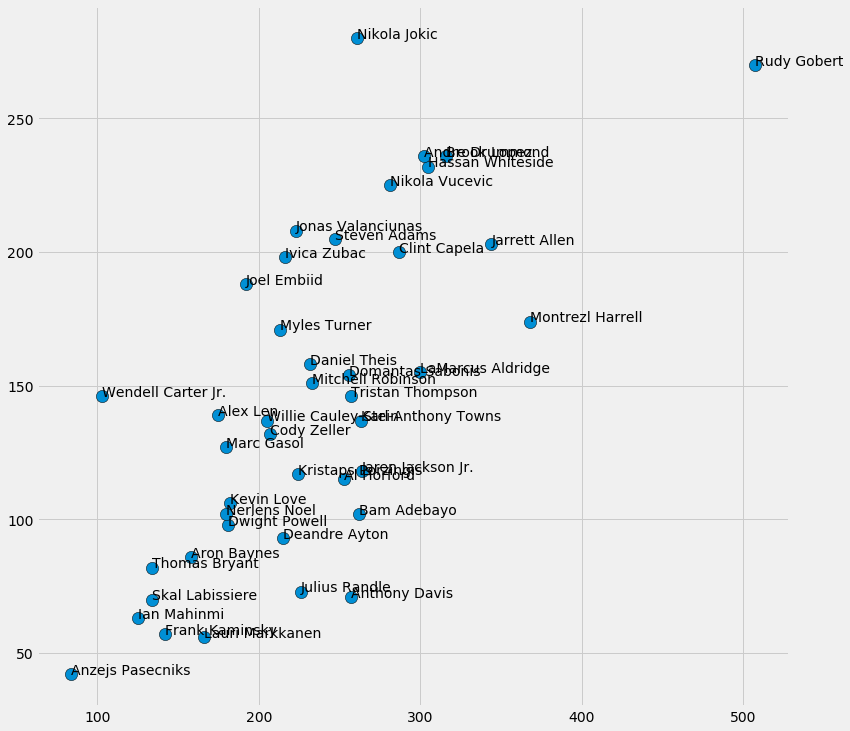

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=merged.MATCHUP_FGA_guards, y=merged.MATCHUP_FGA_centers, s=150, edgecolors='black')

for index in range(len(centers_ten_df)):
    item = centers_ten_df.iloc[index]
    final_item = merged.loc[merged.DEF_PLAYER_NAME_centers == item.PLAYER_NAME].iloc[0]
    ax.text(x=final_item.MATCHUP_FGA_guards, y=final_item.MATCHUP_FGA_centers, s=final_item.DEF_PLAYER_NAME_centers)

In [39]:
#centers_df.loc[:, 'G_F'] = guards_df

In [40]:
forward_list = filtered_forwards.MATCHUP_FGA.tolist()
guard_list = filtered_guards.MATCHUP_FGA.tolist()

In [41]:
sum_list = [item_1 + item_2 for item_1, item_2 in zip(forward_list, guard_list)]

In [42]:
filtered_centers.loc[:, 'G_and_F'] = sum_list

<BarContainer object of 15 artists>

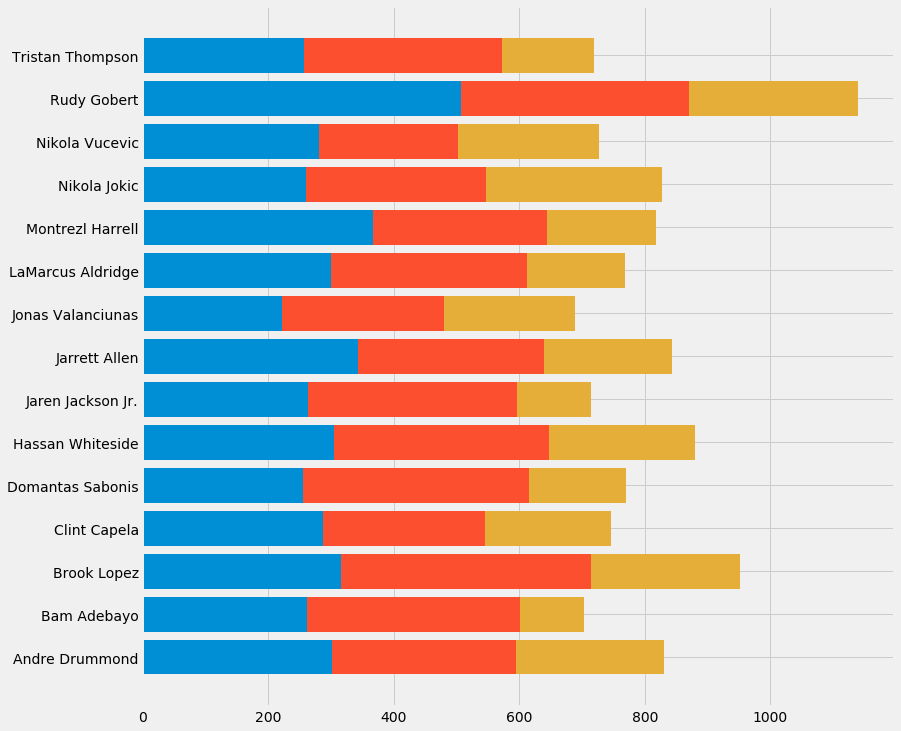

In [43]:
fig, ax = plt.subplots(figsize=(12, 12))
#plt.barh(y, width)
ax.barh(y=filtered_guards.DEF_PLAYER_NAME, width=filtered_guards.MATCHUP_FGA)
ax.barh(y=filtered_forwards.DEF_PLAYER_NAME, width=filtered_forwards.MATCHUP_FGA, left=filtered_guards.MATCHUP_FGA.tolist())
ax.barh(y=filtered_centers.DEF_PLAYER_NAME, width=filtered_centers.MATCHUP_FGA, left=filtered_centers.G_and_F.tolist())

on_off

In [44]:
hustle_url = "https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2019-20&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight="

In [45]:

response = requests.get(hustle_url, headers=headers)
json_data = response.json()
headers = json_data["resultSets"][0]["headers"]
data = json_data["resultSets"][0]["rowSet"]


In [46]:
hustle_df = pd.DataFrame(data=data, columns=headers)

In [47]:
sorted_hustle = hustle_df.sort_values(by='CONTESTED_SHOTS', ascending=False).iloc[:150]

In [48]:
hustle_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,G,MIN,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,...,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB
0,203932,Aaron Gordon,1610612753,ORL,24.0,48,32.0,4.92,3.10,1.81,...,0.532,0.23,0.73,0.96,0.65,0.35,0.239,0.761,0.969,0.531
1,1628988,Aaron Holiday,1610612754,IND,23.0,49,22.8,5.69,2.76,2.94,...,0.500,0.00,0.78,0.78,0.55,0.06,0.000,1.000,0.900,0.100
2,1627846,Abdel Nader,1610612760,OKC,26.0,37,15.1,3.86,2.19,1.68,...,0.526,0.00,0.49,0.49,0.30,0.05,0.000,1.000,0.846,0.154
3,1629690,Adam Mokoka,1610612741,CHI,21.0,6,3.6,0.67,0.00,0.67,...,1.000,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
4,1629678,Admiral Schofield,1610612764,WAS,22.0,26,11.2,2.81,1.73,1.08,...,0.444,0.04,1.19,1.23,0.46,0.12,0.031,0.969,0.857,0.214


In [49]:
hustle_df = hustle_df.loc[hustle_df.G > 20]
hustle_df = hustle_df.loc[hustle_df.MIN > 10]

In [50]:
bucks_hustle = hustle_df.loc[hustle_df.TEAM_ABBREVIATION == 'MIL']
non_bucks = hustle_df.loc[hustle_df.TEAM_ABBREVIATION != 'MIL']

In [51]:
bucks_hustle = bucks_hustle.sort_values(by='CONTESTED_SHOTS', ascending=False)

16

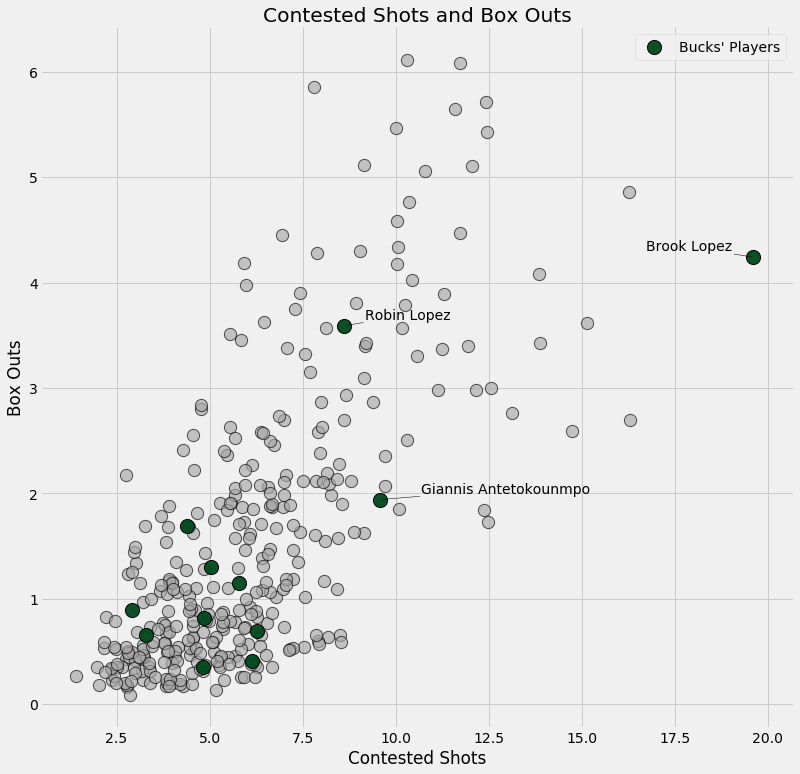

In [53]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=non_bucks.CONTESTED_SHOTS, y=non_bucks.BOX_OUTS, s=150, c='#A8A8A8', edgecolors='black', lw=1, alpha=0.65)
ax.scatter(x=bucks_hustle.CONTESTED_SHOTS, y=bucks_hustle.BOX_OUTS, s=200, c='#00471B', edgecolors='black', lw=1, alpha=0.95, label="Bucks' Players")

ax.set_frame_on(False)

texts = []

for index in range(len(bucks_hustle.iloc[:3])):
    item = bucks_hustle.iloc[index]
    texts.append(ax.text(x=item.CONTESTED_SHOTS, y=item.BOX_OUTS, s=item.PLAYER_NAME))


ax.set_xlabel("Contested Shots")
ax.set_ylabel("Box Outs")
ax.set_title("Contested Shots and Box Outs")
ax.legend()

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.5, 1.5))

# Team restricted area

In [55]:
from nba_api.stats.endpoints.leaguedashptteamdefend import LeagueDashPtTeamDefend

In [56]:
defend_data = LeagueDashPtTeamDefend(defense_category="Less Than 6Ft", per_mode_simple='PerGame')

In [57]:
defend_team_df = defend_data.get_data_frames()[0]

In [58]:
defend_team_df.head()

,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,GP,G,FREQ,FGM_LT_06,FGA_LT_06,LT_06_PCT,NS_LT_06_PCT,PLUSMINUS
0,1610612749,Milwaukee Bucks,MIL,52,52,0.291,13.65,27.35,0.499,0.598,-0.099
1,1610612757,Portland Trail Blazers,POR,53,53,0.356,18.94,32.79,0.578,0.611,-0.034
2,1610612761,Toronto Raptors,TOR,54,54,0.322,16.22,28.26,0.574,0.601,-0.027
3,1610612753,Orlando Magic,ORL,54,54,0.342,17.33,29.28,0.592,0.614,-0.022
4,1610612747,Los Angeles Lakers,LAL,52,52,0.342,17.52,29.88,0.586,0.606,-0.020


In [62]:
bucks_def_df = defend_team_df.loc[defend_team_df.TEAM_ABBREVIATION == 'MIL']
non_bucks_def_df = defend_team_df.loc[defend_team_df.TEAM_ABBREVIATION != 'MIL']

Text(0.5, 1.0, 'Team Defensive Efficiency inside Restricted Area')

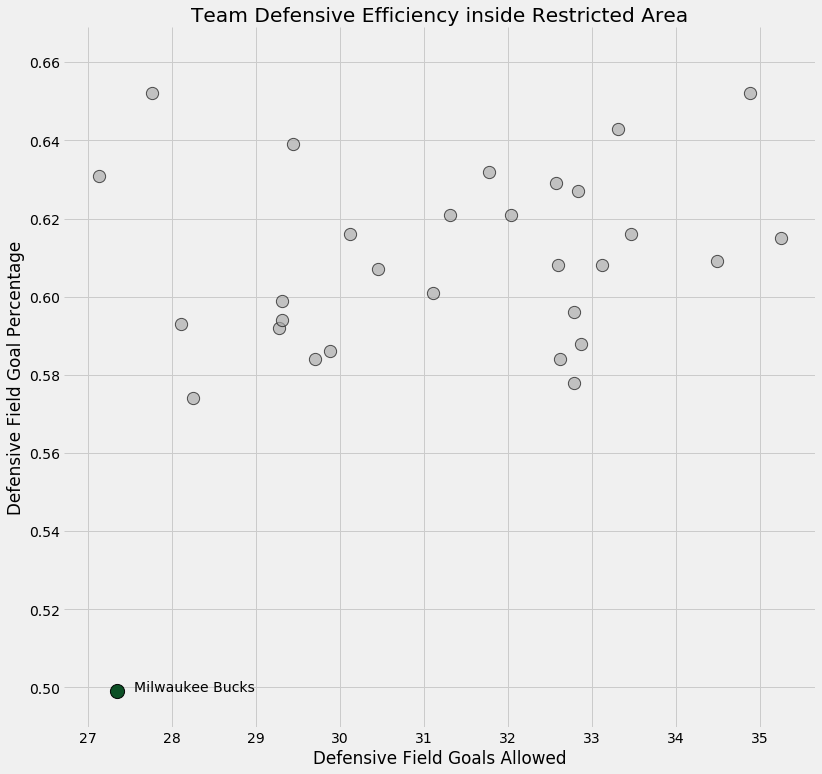

In [68]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=non_bucks_def_df.FGA_LT_06, y=non_bucks_def_df.LT_06_PCT, s=150, c='#A8A8A8', edgecolors='black', lw=1, alpha=0.65)
ax.scatter(x=bucks_def_df.FGA_LT_06, y=bucks_def_df.LT_06_PCT, s=200, c='#00471B', edgecolors='black', lw=1, alpha=0.95)

ax.set_frame_on(False)

texts = []

for index in range(len(bucks_def_df.iloc[:3])):
    item = bucks_def_df.iloc[index]
    texts.append(ax.text(x=item.FGA_LT_06 + 0.2, y=item.LT_06_PCT, s=item.TEAM_NAME))


ax.set_xlabel("Defensive Field Goals Allowed")
ax.set_ylabel("Defensive Field Goal Percentage")
ax.set_title("Team Defensive Efficiency inside Restricted Area")
